# Sales Report Suspiciousness Detection : Prediction


## Problem Description
Classification of reports to different level of Suspiciousness, based on underlying relationship of ProductID & SalesmanID to be used for sales and productivity analysis.


### Business goal
Flag transactions as Suspicious with absolute certainty, to take corrective actions.


### Analysis Objectives

To develop an error/fraud detection software, you are required to develop a method to determine suspicious transactions which have high propensity to be error/fraud. The goal is to verify the veracity of these reports given past experience of the company that has detected both errors and fraud attempts in these transaction reports.

We are expected to create an analytical and modeling framework to predict the propensity of suspicious transaction of each report

### Data Set Description

Data consists of the transaction reports submitted by the salesmen which includes  the salesman ID, report ID, product ID, the quantity and the total value reported by the salesman.


### Algorithm Class

Multi-Class Classification.


### Main Tasks
1. To do exploratory Data Analysis using visualizations
2. Predicting the suspicious transactions using retail salesmen reports analysis (build the analytical framework to predict the propensity of suspicious transaction of each report using the transactions took place.)
3. Salesmen Segmentation (segment the salesmen into different risk categories from the standpoint of propensity to error/fraud which will be used for strategic purposes )

___This Notebook addresses to Taks2 : To build the analytical framework to predict the propensity of suspicious transaction of each report using the transactions took place.___

## Import libraries

In [91]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
import warnings
import os
import random
import matplotlib.pyplot as plt     
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as impipe
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc, accuracy_score,classification_report, recall_score,precision_score,precision_recall_curve,average_precision_score, silhouette_score,roc_curve, auc,confusion_matrix,mean_absolute_error,mean_squared_error,roc_auc_score,f1_score, precision_recall_fscore_support
from sklearn.model_selection import learning_curve
import graphviz
from sklearn import tree
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import math 
from xgboost.sklearn import  XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import graphviz 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm


## Set Environment for Execution

In [2]:
def set_env_var():
    InteractiveShell.ast_node_interactivity = "all"
    warnings.filterwarnings('ignore')
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 60)
    init_notebook_mode(connected=True)
    %matplotlib inline


set_env_var()


## Set Seed for consistent execution

In [3]:
def set_seed(seed=707):
    return random.seed(seed)

seed_constant = 122
set_seed(seed_constant)


## Import required data 

In [4]:
def data_importer_xlsx(data_path, na_values=[]):
    dataF = pd.read_excel(data_path, na_values=na_values)
    print("The number of Rows in the Data set  = "+str(dataF.shape[0]))
    print("The number of Columns in the data set = " +str(dataF.shape[1]))
    return dataF


In [5]:
#Train data
salesReportData=data_importer_xlsx("/Users/samyam/Documents/Samya/GIT/insofe/Final_PHD/PartB/Inputdataset/Actual/Train.xlsx")
salesReportData.head()
salesReportData.shape

The number of Rows in the Data set  = 42582
The number of Columns in the data set = 6


,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
0,Rep10101,C21116,PR6112,182,1665,indeterminate
1,Rep10102,C21116,PR6112,182,1740,indeterminate
2,Rep10103,C21116,PR6253,101,1040,indeterminate
3,Rep10104,C21116,PR6253,283,4495,No
4,Rep10105,C21116,PR6294,108,1465,indeterminate


(42582, 6)

In [6]:
#Test data
salesReportDataTestActual = data_importer_xlsx("/Users/samyam/Documents/Samya/GIT/insofe/Final_PHD/PartB/Inputdataset/Actual/Test.xlsx")
salesReportDataTestActual.head()
salesReportDataTestActual.shape

The number of Rows in the Data set  = 9135
The number of Columns in the data set = 5


,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue
0,Rep70101,C21844,PR6483,102,1115
1,Rep70102,C21844,PR6251,102,1050
2,Rep70103,C21844,PR6253,344,3490
3,Rep70104,C21844,PR6378,108,1095
4,Rep70105,C21844,PR6463,146,1055


(9135, 5)

## Load data for analysis

In [7]:
salesReportDataTrain, salesReportDataTest = train_test_split(salesReportData, test_size=0.25, random_state=seed_constant, stratify=salesReportData['Suspicious'])
print("Train Set shape :",salesReportDataTrain.shape)
print("Test Set shape :",salesReportDataTest.shape)

Train Set shape : (31936, 6)
Test Set shape : (10646, 6)


## Feature Analysis of given data

In [8]:
def data_description(dataF):
    print("The columns in the data set are : \n",list(dataF.columns))
    print("The data types of the columns are :\n\n",dataF.dtypes)
    
data_description(salesReportDataTrain)

The columns in the data set are : 
 ['ReportID', 'SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue', 'Suspicious']
The data types of the columns are :

 ReportID           object
SalesPersonID      object
ProductID          object
Quantity            int64
TotalSalesValue     int64
Suspicious         object
dtype: object


### Check the first and last 5 rows in dataset to get an understanding of data

In [9]:
salesReportDataTrain.head()
salesReportDataTrain.tail()

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
4411,Rep14512,C22230,PR6246,104,1250,indeterminate
268,Rep10369,C21820,PR6165,410,3555,indeterminate
21330,Rep31431,C21179,PR6282,2756,8270,indeterminate
35509,Rep45610,C21453,PR6299,38182,223045,indeterminate
31373,Rep41474,C22267,PR6595,100,1148,No


,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
12782,Rep22883,C21178,PR6358,3446,3730,indeterminate
13866,Rep23967,C22322,PR6210,188,2675,indeterminate
35245,Rep45346,C21483,PR6360,300,8500,indeterminate
1063,Rep11164,C21976,PR6235,106,1005,indeterminate
17992,Rep28093,C22263,PR6492,1307,3845,indeterminate


### Random Sample rows

In [10]:
def get_data_sample(dataF, num_sample=10):
    return pd.DataFrame(dataF.sample(num_sample))

get_data_sample(salesReportDataTrain)

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
22329,Rep32430,C21867,PR6671,132,1750,indeterminate
1385,Rep11486,C21976,PR6153,100,1030,indeterminate
7924,Rep18025,C22153,PR6115,600,3505,indeterminate
16118,Rep26219,C21666,PR6165,102,1440,indeterminate
7044,Rep17145,C22056,PR6616,105,1315,indeterminate
16600,Rep26701,C22233,PR6171,2105,21295,indeterminate
16412,Rep26513,C21921,PR6192,101,1120,indeterminate
9012,Rep19113,C21978,PR6187,433,2105,indeterminate
26176,Rep36277,C21238,PR6249,142,1140,indeterminate
40142,Rep50243,C21658,PR6518,133897,57465,indeterminate


### Distribution of target attribute

indeterminate    29884
No                1916
Yes                136
Name: Suspicious, dtype: int64
indeterminate    93.574649
No                5.999499
Yes               0.425852
Name: Suspicious, dtype: float64


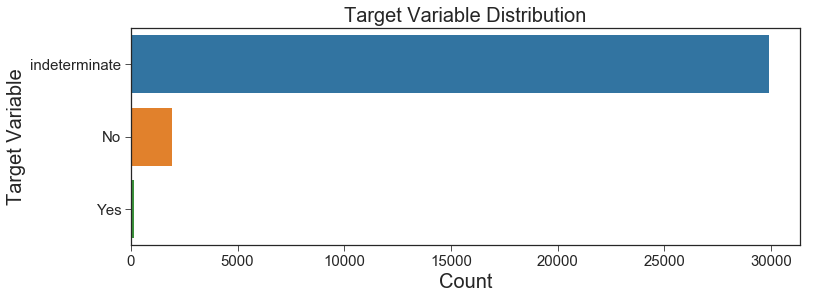

In [11]:
def plot_data_dist_across_targ(dataF, target):
    """
    Plot target variable distribution
    """
    
    print(dataF[target].value_counts())
    print((dataF[target].value_counts()/dataF[target].count())*100)
    
    plt.figure(figsize=(12,4))
    plt.style.use('seaborn-ticks')
    plot_1 = sns.countplot(y=target, data=dataF, order = dataF[target].value_counts().index);
    plot_1.axes.set_title("Target Variable Distribution",fontsize=20);
    plot_1.set_xlabel("Count",fontsize=20);
    plot_1.set_ylabel("Target Variable",fontsize=20);
    plot_1.tick_params(labelsize=15);
    plt.show();

    
plot_data_dist_across_targ(salesReportDataTrain, "Suspicious")

### Check count of null in each column & its percent

In [12]:
def get_null_count_per_attribute(dataF): 
    return pd.DataFrame({'total_missing': dataF.isnull().sum(), 
                         'perc_missing': (dataF.isnull().sum()/dataF.shape[0])*100}).sort_values(
        by=['perc_missing'], ascending=False)

get_null_count_per_attribute(salesReportDataTrain)

,total_missing,perc_missing
ReportID,0,0.0
SalesPersonID,0,0.0
ProductID,0,0.0
Quantity,0,0.0
TotalSalesValue,0,0.0
Suspicious,0,0.0


### Check for count of unique values in different attriutes

In [13]:
def get_unique_value_count_per_attribute(dataF): 
    return pd.DataFrame((dataF.nunique()/dataF.shape[0])*100).rename(
        {0: 'perc_unique'}, axis=1).sort_values(by=['perc_unique'])

get_unique_value_count_per_attribute(salesReportDataTrain)

,perc_unique
Suspicious,0.009394
ProductID,1.847445
SalesPersonID,3.087425
Quantity,17.422345
TotalSalesValue,20.916834
ReportID,100.000000


### Duplicate analysis

#### Dedup dataset

Identify and drop rows that are duplicate after dropping ReportID

In [14]:
def isDuplicatesPresent(dataF, dropSegColumn=[]):
    print("The number of Rows in the Data set  = "+str(dataF.shape[0]))
    print("The number of Rows in the Dedup Data set  = "+str(dataF.drop(dropSegColumn, axis=1).drop_duplicates().shape[0]))
    
isDuplicatesPresent(salesReportDataTrain, dropSegColumn = "ReportID")

The number of Rows in the Data set  = 31936
The number of Rows in the Dedup Data set  = 25532


#### Distribution of target for same independent variables

In [15]:
salesReportDataTrain_identify_suspicious_redundancy = salesReportDataTrain.drop(
    'ReportID', axis=1).drop_duplicates().groupby(
    ['SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue']).count().reset_index().rename(
    columns= {'Suspicious' : 'count_Suspicious'})

salesReportDataTrain_identify_suspicious_redundancy[
    salesReportDataTrain_identify_suspicious_redundancy['count_Suspicious'] > 1].head()

,SalesPersonID,ProductID,Quantity,TotalSalesValue,count_Suspicious
11,C21118,PR6202,192866,384780,2
162,C21128,PR6437,1226,210450,2
467,C21145,PR6253,100,1122,2
478,C21145,PR6253,111,2505,2
498,C21145,PR6253,570,6295,2


__Observations__

1. Data is highly imbalanced based on target(Suspicious)
2. No missing values in any field.
3. ReportID is unique across all rows, hence can be dropped.
4. Same data sent as part of multiple reports. Possibility of similar sales
5. SalesPersonID, ProductID is not unique across each row
6. There are many scenarios when the same Independent variables are assigned two different Suspicious levels.

### Drop attributes and rows
__That are monotonically increasing or having many nulls or that doesn't have significance to analysis__

__Action__

1. Drop ReportID column.

In [16]:
salesReportDataTrain_dropped_repId = salesReportDataTrain.drop(['ReportID'], axis=1)
salesReportDataTrain_dropped_repId.head()
salesReportDataTrain_dropped_repId.shape

,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
4411,C22230,PR6246,104,1250,indeterminate
268,C21820,PR6165,410,3555,indeterminate
21330,C21179,PR6282,2756,8270,indeterminate
35509,C21453,PR6299,38182,223045,indeterminate
31373,C22267,PR6595,100,1148,No


(31936, 5)

## DataType Conversions

__Observations__

__1. Categorical datatype:__
SalesPersonID, ProductID, Suspicious

__2. Numeric datatype:__
Quantity, TotalSalesValue

In [17]:
salesReportDataTrain_dropped_repId.dtypes

SalesPersonID      object
ProductID          object
Quantity            int64
TotalSalesValue     int64
Suspicious         object
dtype: object

In [18]:
cat_col = ['SalesPersonID', 'ProductID', 'Suspicious']
num_col = np.setdiff1d(salesReportDataTrain_dropped_repId.columns, cat_col).tolist()

cat_col
num_col


['SalesPersonID', 'ProductID', 'Suspicious']

['Quantity', 'TotalSalesValue']

In [19]:
def covert_var(dataF, conversion_type):
    if(conversion_type=="cat"):
        converted_dataF = dataF.astype('category', copy=True)
    if(conversion_type=="num_float"):
        converted_dataF = dataF.astype('float64', copy=True)
    if(conversion_type=="num_int"):
        converted_dataF = dataF.astype('int64', copy=True)
    return converted_dataF


In [20]:
#Do the datatype conversion
salesReportDataTrain_dropped_repId[cat_col] = covert_var(salesReportDataTrain_dropped_repId[cat_col], "cat")
salesReportDataTrain_dropped_repId[num_col] = covert_var(salesReportDataTrain_dropped_repId[num_col], "num_float")    

salesReportDataTrain_dropped_repId.head()
salesReportDataTrain_dropped_repId.dtypes

,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
4411,C22230,PR6246,104.0,1250.0,indeterminate
268,C21820,PR6165,410.0,3555.0,indeterminate
21330,C21179,PR6282,2756.0,8270.0,indeterminate
35509,C21453,PR6299,38182.0,223045.0,indeterminate
31373,C22267,PR6595,100.0,1148.0,No


SalesPersonID      category
ProductID          category
Quantity            float64
TotalSalesValue     float64
Suspicious         category
dtype: object

## Base algorithm - No Redundant data

__Note__ : As this is a base algo we are using OHE directly on Categorical columns, expecting the number of columns will explode

__Drop rows that have more than one Independent variable for the same Dependent variable__

In [21]:
salesReportDataTrain_grped = salesReportDataTrain_dropped_repId.groupby(
    ['SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue']).Suspicious.nunique().reset_index().rename(
    {'Suspicious':'Suspicious_unique_count'}, axis=1)
salesReportDataTrain_grped_more_than_one = salesReportDataTrain_grped[
    salesReportDataTrain_grped.Suspicious_unique_count>1]

common = salesReportDataTrain_grped_more_than_one.merge(salesReportDataTrain_dropped_repId,on=['SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue'])
salesReportDataTrain_filtered_redundancy = salesReportDataTrain_dropped_repId[~(
    (salesReportDataTrain_dropped_repId.SalesPersonID.isin(common.SalesPersonID))&
    (salesReportDataTrain_dropped_repId.ProductID.isin(common.ProductID))&
    (salesReportDataTrain_dropped_repId.Quantity.isin(common.Quantity))&
    (salesReportDataTrain_dropped_repId.TotalSalesValue.isin(common.TotalSalesValue)))]

salesReportDataTrain_filtered_redundancy.head()
salesReportDataTrain_filtered_redundancy.shape

,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
4411,C22230,PR6246,104.0,1250.0,indeterminate
268,C21820,PR6165,410.0,3555.0,indeterminate
21330,C21179,PR6282,2756.0,8270.0,indeterminate
35509,C21453,PR6299,38182.0,223045.0,indeterminate
4568,C21885,PR6131,320.0,1805.0,indeterminate


(31444, 5)

### Distribution of target attribute after de-dup

indeterminate    29522
No                1791
Yes                131
Name: Suspicious, dtype: int64
indeterminate    93.887546
No                5.695840
Yes               0.416614
Name: Suspicious, dtype: float64


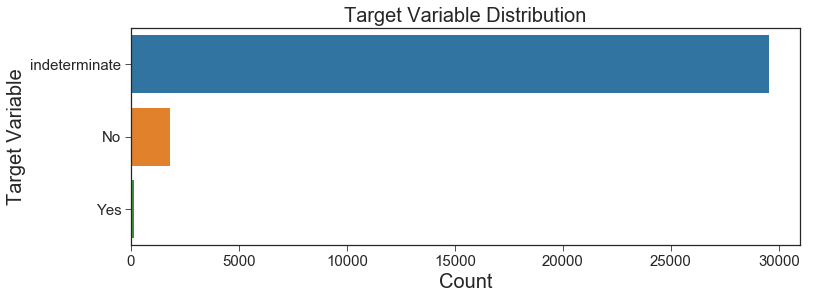

In [22]:
plot_data_dist_across_targ(salesReportDataTrain_filtered_redundancy, "Suspicious")

In [23]:
salesReportDataTrain_filtered_redundancy.dtypes

SalesPersonID      category
ProductID          category
Quantity            float64
TotalSalesValue     float64
Suspicious         category
dtype: object

###  Segment the data into IV & DV

In [24]:
X_train = salesReportDataTrain_filtered_redundancy.drop('Suspicious', axis=1)
y_train = salesReportDataTrain_filtered_redundancy['Suspicious']

In [25]:
num_col_split = list(X_train.select_dtypes(include='float').columns)
cat_col_split = list(X_train.select_dtypes(include='category').columns)

num_col_split
cat_col_split

['Quantity', 'TotalSalesValue']

['SalesPersonID', 'ProductID']

### Impute and scale attributes

In [26]:
def define_num_transformer(**transformers):
    steps=[]
    for key, value in transformers.items():
        if(key == "imputer"):
            steps.append((key, SimpleImputer(strategy=value)))
        elif(key == "scaler"):
            steps.append((key, StandardScaler()))
        else:
            return "Not a valid transformation"    
    return Pipeline(memory ='./' ,steps=steps)


def define_cat_transformer(**transformers):
    steps=[]
    for key, value in transformers.items():
        if(key == "imputer"):
            steps.append(('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')))
        elif(key == "dummyfication_onehot"):
            steps.append(('onehot', OneHotEncoder(handle_unknown='ignore')))
        else:
            return "Not a valid transformation"
    return Pipeline(memory ='./' ,steps=steps)


def get_column_transformer(num_transformer=None, num_col_split=None, cat_transformer=None, cat_col_split=None):
    transformer_step=[]
    if(num_transformer != None):
        transformer_step.append(('num', num_transformer, num_col_split))
    if(cat_transformer != None):
        transformer_step.append(('cat', cat_transformer, cat_col_split))
    return ColumnTransformer(transformers=transformer_step)        


### Custom Scoring

As we are interested only in Recall of Yes, a custom score is required to capture the same as part of Cross validation.

In [27]:
def custom_recall_score(ground_truth, predictions):
    return recall_score(ground_truth, predictions, labels=['Yes'], average=None)

cust_recall_score = make_scorer(custom_recall_score, greater_is_better=True)

### Build pipeline

In [28]:
num_transformer_step = {"scaler":"StandardScaler", "imputer":"mean"}
num_transformer = define_num_transformer(**num_transformer_step)

cat_transformer_step = {"dummyfication_onehot":"OneHotEncoder"}
cat_transformer = define_cat_transformer(**cat_transformer_step)

preprocessor = get_column_transformer(num_transformer, num_col_split, cat_transformer, cat_col_split)
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory='./',
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0))]), ['Quantity', 'TotalSalesValue']), ('cat', Pipeline(memory='./...'>, handle_unknown='ignore',
       n_values=None, sparse=True))]), ['SalesPersonID', 'ProductID'])])

In [29]:
def add_to_pipeline(**final_pipeline_steps):
    steps=[]
    for key, value in final_pipeline_steps.items():
        if(key == "preprocessor"):
            steps.append(('preprocessor', value))
        elif(key == "baseModel"):
            steps.append(('classifier', value))
        else:
            return "Not a valid step"
    return impipe(steps=steps)


In [30]:
#Pipeline steps to be added to imBalance pipeline
baseModel = LogisticRegression()
steps = {"preprocessor" : preprocessor, "baseModel": baseModel}
im_pipe_clf = add_to_pipeline(**steps)

### Grid Search

In [31]:
def simple_calssification_grid_space():
    return [{'classifier': [LogisticRegression()],
             'classifier__C': [3,7],
             'classifier__penalty': ["l1","l2"],
             'classifier__class_weight': [None, "balanced"]},
            {'classifier': [DecisionTreeClassifier(random_state=0)],
             'classifier__max_depth': [2,3,5,9],
             'classifier__class_weight': [None, "balanced"]}]

In [32]:
#Search Space for base classifier
search_space = simple_calssification_grid_space()

#Define repeated KFold
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

CV_grid_model = GridSearchCV(
    estimator=im_pipe_clf, param_grid=search_space, cv= rkf, scoring=cust_recall_score, n_jobs=-1, verbose=3, refit=True)
CV_grid_model.fit(X=X_train, y=y_train)


Fitting 30 folds for each of 16 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.8min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1c23f865c0>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory='./',
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('imputer', SimpleImputer(copy=True...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'classifier': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)], 'class...er='best')], 'classifier__max_depth': [2, 3, 5, 9], 'classifier__c

In [33]:
def get_grid_summary(gs_model):
    print('Best score = ', gs_model.best_score_)
    print('\n')
    
    print('Best parameter : ')
    print(gs_model.best_params_)    
    print('\n')
    
    print('Best Model : ')
    print(gs_model.best_estimator_.get_params()['classifier'])
    print('\n')
    
    print('Grid search execution stat :')
    return pd.DataFrame(gs_model.cv_results_)

In [34]:
get_grid_summary(CV_grid_model)

Best score =  0.7440621525275571


Best parameter : 
{'classifier': DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'), 'classifier__class_weight': 'balanced', 'classifier__max_depth': 5}


Best Model : 
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')


Grid search execution stat :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__class_weight,param_classifier__penalty,param_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,3.536340,0.174559,0.097949,0.011742,"LogisticRegression(C=1.0, class_weight=None, d...",3,None,l1,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.033613,0.034188,0.033898,0.026549,0.025424,0.032258,0.033333,0.026087,0.025641,0.026316,0.025641,0.041667,0.016807,0.042017,0.034783,0.042017,0.025210,0.041667,0.034483,0.026087,0.035714,0.043860,0.040650,0.050000,0.024793,0.033613,0.033898,0.041322,0.033896,0.008020
1,1.234774,0.123490,0.082277,0.028290,"LogisticRegression(C=1.0, class_weight=None, d...",3,None,l2,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000285,0.001534
2,17.402749,0.945508,0.126510,0.015202,"LogisticRegression(C=1.0, class_weight=None, d...",3,balanced,l1,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.066667,0.083333,0.083333,0.214286,0.230769,0.000000,0.000000,0.000000,0.000000,0.0000,0.071429,0.058824,0.071429,0.181818,0.000000,0.083333,0.0625,0.250000,0.166667,0.181818,...,0.789916,0.769231,0.822034,0.831858,0.805085,0.814516,0.808333,0.782609,0.786325,0.807018,0.794872,0.800000,0.781513,0.781513,0.826087,0.815126,0.806723,0.783333,0.793103,0.791304,0.821429,0.815789,0.772358,0.791667,0.834711,0.789916,0.796610,0.801653,0.801344,0.017002
3,2.794299,0.207357,0.119028,0.017019,"LogisticRegression(C=1.0, class_weight=None, d...",3,balanced,l2,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.066667,0.166667,0.083333,0.214286,0.230769,0.111111,0.000000,0.000000,0.000000,0.0000,0.071429,0.058824,0.142857,0.090909,0.000000,0.083333,0.0625,0.250000,0.166667,0.090909,...,0.798319,0.777778,0.779661,0.796460,0.796610,0.782258,0.800000,0.765217,0.786325,0.771930,0.786325,0.766667,0.773109,0.781513,0.800000,0.781513,0.773109,0.758333,0.775862,0.782609,0.803571,0.780702,0.756098,0.758333,0.818182,0.781513,0.805085,0.768595,0.782971,0.015649
4,9.431532,0.306546,0.116241,0.011050,"LogisticRegression(C=1.0, class_weight=None, d...",7,None,l1,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.067227,0.051282,0.067797,0.061947,0.059322,0.056452,0.066667,0.060870,0.059829,0.0

### Plot Learning curve

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize = (8,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=cust_recall_score)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


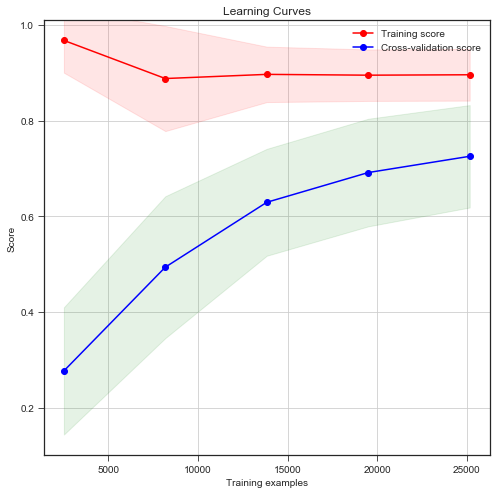

In [36]:
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


steps = {"preprocessor" : preprocessor}
im_pipe_pre_process = add_to_pipeline(**steps)
estimator = CV_grid_model.best_estimator_.get_params()['classifier']
title = r"Learning Curves"
plot_learning_curve(estimator, title, im_pipe_pre_process.fit_transform(X_train), y_train, 
                       (0.1, 1.01), cv=cv, n_jobs=-1)

### Training data evaluation

In [37]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print("Accuracy score :", accuracy_score(y,y_pred))
    print("classification_report :\n",classification_report(y,y_pred,digits=4))
    return y_pred

In [38]:
y_pred = evaluate_model(CV_grid_model, X_train, y_train)
y_pred

Accuracy score : 0.6299771021498537
classification_report :
                precision    recall  f1-score   support

           No     0.1180    0.7655    0.2044      1791
          Yes     0.1049    0.8855    0.1876       131
indeterminate     0.9790    0.6206    0.7597     29522

    micro avg     0.6300    0.6300    0.6300     31444
    macro avg     0.4006    0.7572    0.3839     31444
 weighted avg     0.9263    0.6300    0.7257     31444



array(['No', 'indeterminate', 'indeterminate', ..., 'indeterminate', 'No',
       'indeterminate'], dtype=object)

### Confusion matrix

In [39]:
def plot_confusion_matrix(y, y_pred):
    lables = list(set(y))
    ax= plt.subplot()
    cm = confusion_matrix(y, y_pred,lables)
    sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu");
    print(cm)
    
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(lables);
    ax.yaxis.set_ticklabels(lables);


[[ 1371    33   387]
 [    9   116     6]
 [10243   957 18322]]


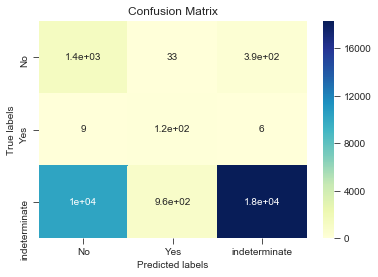

In [40]:
plot_confusion_matrix(y_train,y_pred)

__Observations__

1. DecisionTreeClassifier performs the best amongst the tried classifiers.
2. A learning curve shows how error changes as the training set size increases. Learning curves give us an opportunity to diagnose bias and variance in supervised learning models.
3. The training scores is high & validation score is comparatively much lower. __High Variance Problem__. As we are classifying a given report by a salesman as Suspicious, we need to be absolutely sure before defaming, hence VERY high Recall required.
7. As its a high variance problem, training the current learning algorithm needs to generalize.
8. We should also try out bagging algo like Random forest etc.
9. Also to note is, the training error is also in the range of 87-90%, which can be tackled by improving features.

### Evaluate the model on test data

In [41]:
#Drop ReportID column, as in case of train
salesReportDataTest_dropped_attr_no_dup = salesReportDataTest.drop(['ReportID'], axis=1)

# Datatype conversions
salesReportDataTest_dropped_attr_no_dup[cat_col] = covert_var(salesReportDataTest_dropped_attr_no_dup[cat_col], "cat")
salesReportDataTest_dropped_attr_no_dup[num_col] = covert_var(salesReportDataTest_dropped_attr_no_dup[num_col], "num_float")    

X_test = salesReportDataTest_dropped_attr_no_dup.drop('Suspicious', axis=1)
y_test = salesReportDataTest_dropped_attr_no_dup['Suspicious']


y_test_pred = evaluate_model(CV_grid_model, X_test, y_test)
y_test_pred

Accuracy score : 0.6227691151606237
classification_report :
                precision    recall  f1-score   support

           No     0.1171    0.7277    0.2018       639
          Yes     0.0659    0.5333    0.1174        45
indeterminate     0.9729    0.6164    0.7547      9962

    micro avg     0.6228    0.6228    0.6228     10646
    macro avg     0.3853    0.6258    0.3579     10646
 weighted avg     0.9177    0.6228    0.7188     10646



array(['indeterminate', 'indeterminate', 'indeterminate', ..., 'No', 'No',
       'indeterminate'], dtype=object)

[[ 465    9  165]
 [  15   24    6]
 [3490  331 6141]]


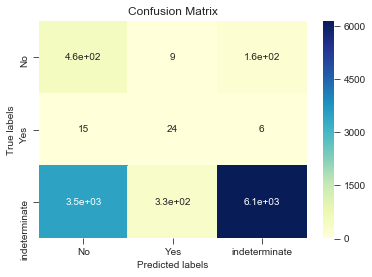

In [42]:
plot_confusion_matrix(y_test,y_test_pred)

### ROC/ AUC 
Evaluate selected model

In [43]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)[lb.classes_=='Yes']


In [44]:
multiclass_roc_auc_score(y_test,y_test_pred, average=None)

array([0.75063044])

__Observation__
1. Recall of 54 % (Suspicious=YES) is observed on test data as compared to 88% on train, hinting Over-fitting.

## Base algorithm - Redundant data
__Keep rows that have more than one Independent variable for the same Dependent variable__

In [45]:
salesReportDataTrain_dropped_repId.dtypes

SalesPersonID      category
ProductID          category
Quantity            float64
TotalSalesValue     float64
Suspicious         category
dtype: object

### Segment the data into IV & DV

In [46]:
X_train = salesReportDataTrain_dropped_repId.drop('Suspicious', axis=1)
y_train = salesReportDataTrain_dropped_repId['Suspicious']

In [47]:
num_col_split = list(X_train.select_dtypes(include='float').columns)
cat_col_split = list(X_train.select_dtypes(include='category').columns)

num_col_split
cat_col_split

['Quantity', 'TotalSalesValue']

['SalesPersonID', 'ProductID']

In [48]:
num_transformer_step = {"scaler":"StandardScaler", "imputer":"mean"}
num_transformer = define_num_transformer(**num_transformer_step)

cat_transformer_step = {"dummyfication_onehot":"OneHotEncoder"}
cat_transformer = define_cat_transformer(**cat_transformer_step)

preprocessor = get_column_transformer(num_transformer, num_col_split, cat_transformer, cat_col_split)
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory='./',
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0))]), ['Quantity', 'TotalSalesValue']), ('cat', Pipeline(memory='./...'>, handle_unknown='ignore',
       n_values=None, sparse=True))]), ['SalesPersonID', 'ProductID'])])

### Build pipeline

In [49]:
#Pipeline steps to be added to imBalance pipeline
baseModel = LogisticRegression()
steps = {"preprocessor" : preprocessor, "baseModel": baseModel}
im_pipe_clf = add_to_pipeline(**steps)

### Grid Search

In [50]:
def simple_calssification_grid_space():
    return [{'classifier': [LogisticRegression()],
             'classifier__C': [3,7],
             'classifier__penalty': ["l1","l2"],
             'classifier__class_weight': [None, "balanced"]},
            {'classifier': [DecisionTreeClassifier(random_state=0)],
             'classifier__max_depth': [2,3,5,9],
             'classifier__class_weight': [None, "balanced"]}]

In [51]:
#Search Space for base classifier
search_space = simple_calssification_grid_space()

#Define repeated KFold
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)


CV_grid_model = GridSearchCV(
    estimator=im_pipe_clf, param_grid=search_space, cv= rkf, scoring=cust_recall_score, n_jobs=-1, verbose=3, refit=True)
CV_grid_model.fit(X=X_train, y=y_train)


Fitting 30 folds for each of 16 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.7min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1c22f9f6a0>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory='./',
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('imputer', SimpleImputer(copy=True...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'classifier': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)], 'class...er='best')], 'classifier__max_depth': [2, 3, 5, 9], 'classifier__c

In [52]:
get_grid_summary(CV_grid_model)

Best score =  0.7308290188964438


Best parameter : 
{'classifier': DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'), 'classifier__class_weight': 'balanced', 'classifier__max_depth': 5}


Best Model : 
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')


Grid search execution stat :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__class_weight,param_classifier__penalty,param_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,3.696705,0.233978,0.100065,0.013121,"LogisticRegression(C=1.0, class_weight=None, d...",3,None,l1,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.032520,0.040650,0.056452,0.033058,0.033898,0.039062,0.032787,0.033613,0.032,0.024194,0.040650,0.042373,0.016667,0.034188,0.040323,0.054264,0.024194,0.050000,0.032520,0.032787,0.031746,0.043103,0.032520,0.032,0.039683,0.024194,0.024590,0.034188,0.035376,0.008547
1,1.694092,0.122016,0.110716,0.022055,"LogisticRegression(C=1.0, class_weight=None, d...",3,None,l2,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.008065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000269,0.001448
2,12.817361,2.308200,0.085435,0.018388,"LogisticRegression(C=1.0, class_weight=None, d...",3,balanced,l1,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.181818,0.200000,0.000000,0.076923,0.000000,0.066667,0.222222,0.125,0.071429,0.176471,0.090909,0.083333,0.076923,0.166667,0.1875,0.210526,0.083333,0.142857,0.083333,0.1250,...,0.788618,0.829268,0.814516,0.818182,0.779661,0.804688,0.803279,0.806723,0.808,0.798387,0.796748,0.788136,0.816667,0.829060,0.822581,0.821705,0.822581,0.800000,0.780488,0.827869,0.785714,0.827586,0.772358,0.776,0.793651,0.814516,0.786885,0.820513,0.804543,0.017029
3,1.855523,0.323325,0.077638,0.015262,"LogisticRegression(C=1.0, class_weight=None, d...",3,balanced,l2,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.090909,0.200000,0.000000,0.076923,0.000000,0.066667,0.222222,0.125,0.071429,0.176471,0.090909,0.083333,0.076923,0.166667,0.2500,0.210526,0.083333,0.142857,0.083333,0.1250,...,0.804878,0.796748,0.830645,0.809917,0.788136,0.796875,0.795082,0.823529,0.800,0.822581,0.796748,0.796610,0.775000,0.786325,0.806452,0.790698,0.814516,0.783333,0.804878,0.819672,0.761905,0.818966,0.796748,0.808,0.785714,0.814516,0.786885,0.794872,0.799036,0.015741
4,5.265250,0.236128,0.061788,0.007068,"LogisticRegression(C=1.0, class_weight=None, d...",7,None,l1,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.048780,0.048780,0.064516,0.066116,0.059322,0.078125,0.057377,0.075630,0.080,0.040323,0.073171,0.059322,0.058333,0.059829,

### Plot Learning curve

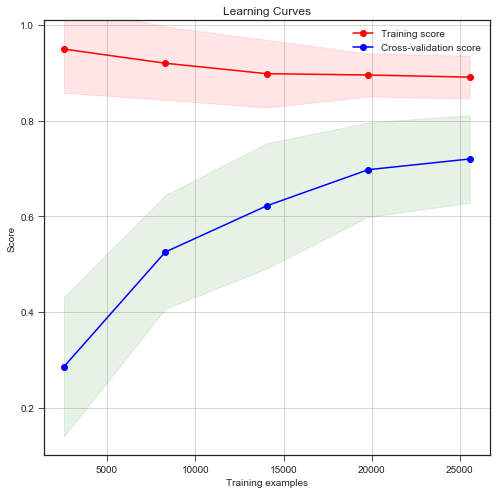

In [53]:
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


steps = {"preprocessor" : preprocessor}
im_pipe_pre_process = add_to_pipeline(**steps)
estimator = CV_grid_model.best_estimator_.get_params()['classifier']
title = r"Learning Curves"
plot_learning_curve(estimator, title, im_pipe_pre_process.fit_transform(X_train), y_train, 
                       (0.1, 1.01), cv=cv, n_jobs=-1)

### Training data evaluation

In [54]:
y_pred = evaluate_model(CV_grid_model, X_train, y_train)
y_pred

Accuracy score : 0.6188940380761523
classification_report :
                precision    recall  f1-score   support

           No     0.1206    0.7698    0.2085      1916
          Yes     0.1065    0.8750    0.1899       136
indeterminate     0.9777    0.6081    0.7498     29884

    micro avg     0.6189    0.6189    0.6189     31936
    macro avg     0.4016    0.7510    0.3827     31936
 weighted avg     0.9226    0.6189    0.7149     31936



array(['No', 'indeterminate', 'indeterminate', ..., 'indeterminate', 'No',
       'indeterminate'], dtype=object)

### Confusion matrix

[[ 1475    34   407]
 [   10   119     7]
 [10749   964 18171]]


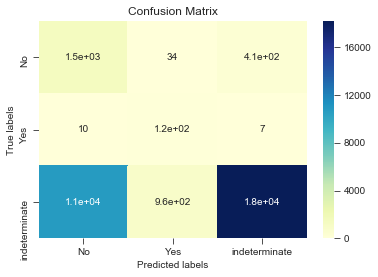

In [55]:
plot_confusion_matrix(y_train,y_pred)

### Evaluate the model on test data

In [56]:
#Drop ReportID column, as in case of train
salesReportDataTest_dropped_attr_no_dup = salesReportDataTest.drop(['ReportID'], axis=1)

# Datatype conversions
salesReportDataTest_dropped_attr_no_dup[cat_col] = covert_var(salesReportDataTest_dropped_attr_no_dup[cat_col], "cat")
salesReportDataTest_dropped_attr_no_dup[num_col] = covert_var(salesReportDataTest_dropped_attr_no_dup[num_col], "num_float")    

X_test = salesReportDataTest_dropped_attr_no_dup.drop('Suspicious', axis=1)
y_test = salesReportDataTest_dropped_attr_no_dup['Suspicious']


y_test_pred = evaluate_model(CV_grid_model, X_test, y_test)
y_test_pred

Accuracy score : 0.6157242156678565
classification_report :
                precision    recall  f1-score   support

           No     0.1157    0.7340    0.1999       639
          Yes     0.0661    0.5333    0.1176        45
indeterminate     0.9732    0.6085    0.7488      9962

    micro avg     0.6157    0.6157    0.6157     10646
    macro avg     0.3850    0.6253    0.3554     10646
 weighted avg     0.9179    0.6157    0.7132     10646



array(['indeterminate', 'indeterminate', 'indeterminate', ..., 'No', 'No',
       'indeterminate'], dtype=object)

[[ 469    9  161]
 [  15   24    6]
 [3570  330 6062]]


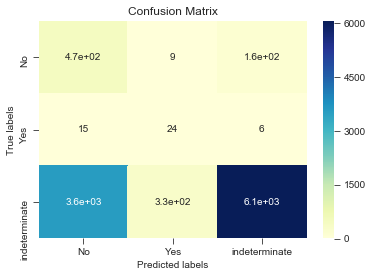

In [57]:
plot_confusion_matrix(y_test,y_test_pred)

### ROC/ AUC 
Evaluate selected model

In [58]:
multiclass_roc_auc_score(y_test,y_test_pred, average=None)

array([0.75067761])

__Observation__
1. No change in Recall, still over-fitting

## Tune Algorithm

Using the derived columns to model

__Drop rows that have more than one Independent variable for the same Dependent variable__

In [59]:
salesReportDataTrain_grped = salesReportDataTrain_dropped_repId.groupby(
    ['SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue']).Suspicious.nunique().reset_index().rename(
    {'Suspicious':'Suspicious_unique_count'}, axis=1)
salesReportDataTrain_grped_more_than_one = salesReportDataTrain_grped[
    salesReportDataTrain_grped.Suspicious_unique_count>1]

common = salesReportDataTrain_grped_more_than_one.merge(salesReportDataTrain_dropped_repId,on=['SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue'])
salesReportDataTrain_filtered_redundancy = salesReportDataTrain_dropped_repId[~(
    (salesReportDataTrain_dropped_repId.SalesPersonID.isin(common.SalesPersonID))&
    (salesReportDataTrain_dropped_repId.ProductID.isin(common.ProductID))&
    (salesReportDataTrain_dropped_repId.Quantity.isin(common.Quantity))&
    (salesReportDataTrain_dropped_repId.TotalSalesValue.isin(common.TotalSalesValue)))]

salesReportDataTrain_filtered_redundancy.head()
salesReportDataTrain_filtered_redundancy.shape

,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
4411,C22230,PR6246,104.0,1250.0,indeterminate
268,C21820,PR6165,410.0,3555.0,indeterminate
21330,C21179,PR6282,2756.0,8270.0,indeterminate
35509,C21453,PR6299,38182.0,223045.0,indeterminate
4568,C21885,PR6131,320.0,1805.0,indeterminate


(31444, 5)

### Feature Generation


#### Define feature generation transformer

In [60]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    """Extract features from each row"""
    
    def __init__(self):
        self.fAggrOnP = None
        
    def fit(self, X, y=None):
        self.fAggrOnP = X.groupby('ProductID').agg({'TotalSalesValue':'sum','Quantity':'sum'})
        self.fAggrOnP['ProductWiseASP'] = self.fAggrOnP.TotalSalesValue/self.fAggrOnP.Quantity
        self.fAggrOnP = self.fAggrOnP.rename(index=str,columns={'TotalSalesValue':'TotalValuePerProduct',
                                                          'Quantity':'TotalQuantityPerProduct'})
        self.fAggrOnP1 = X.groupby('ProductID').agg({'SalesPersonID':'count'})
        self.fAggrOnP1 = self.fAggrOnP1.rename(index=str,columns={'SalesPersonID':'CountOfTransPerProduct'})
        
        self.fAggrOnP2 = X.groupby('ProductID').agg({'Quantity':'median'})
        self.fAggrOnP2 = self.fAggrOnP2.rename(index=str,columns={'Quantity':'MedianQtySoldPerPrd'})
        
        self.fAggrOnP3 = X.groupby('ProductID').agg({'TotalSalesValue':'median'})
        self.fAggrOnP3 = self.fAggrOnP3.rename(index=str,columns={'TotalSalesValue':'MedianTotalSalesValuePerPrd'})

        self.fAggrOnP4_1 = X[['ProductID','TotalSalesValue','Quantity']].copy()
        self.fAggrOnP4_1['TransactionWiseASP_1'] = self.fAggrOnP4_1.TotalSalesValue / self.fAggrOnP4_1.Quantity
        self.fAggrOnP4 = self.fAggrOnP4_1.groupby('ProductID').agg({'TransactionWiseASP_1':'median'})
        self.fAggrOnP4 = self.fAggrOnP4.rename(index=str,columns={'TransactionWiseASP_1':'MedianTransactionWiseSP'})
        
        return self

    
    
    
    def transform(self, X, y=None):
        X = X.join(self.fAggrOnP,on='ProductID')
        X = X.join(self.fAggrOnP1,on='ProductID')
        X = X.join(self.fAggrOnP2,on='ProductID')
        X = X.join(self.fAggrOnP3,on='ProductID')
        X = X.join(self.fAggrOnP4,on='ProductID')
        X['TransactionWiseASP'] = X.TotalSalesValue / X.Quantity
        X['DiffInPrice'] = X['TransactionWiseASP'] - X['ProductWiseASP']
        X['percDiffInPrice'] = X['DiffInPrice'] / X['ProductWiseASP']
        X['ProductQtyRatioPerTrans'] = X['Quantity'] / X['TotalQuantityPerProduct']
        X['AvgQuantityOfProductsSoldPerTransAtProductLevel'] = X['TotalQuantityPerProduct'] / X['CountOfTransPerProduct']
        X['QtyRatioOfTransFromMean'] = X['Quantity'] / X['AvgQuantityOfProductsSoldPerTransAtProductLevel']
        
        X['ProductRevRatioPerTrans'] = X['TotalSalesValue'] / X['TotalValuePerProduct']
        X['AvgSaleesValueOfTransactionAtProductLevel'] = X['TotalValuePerProduct'] / X['CountOfTransPerProduct']
        X['ValueRatioOfTransFromMean'] = X['TotalSalesValue'] / X['AvgSaleesValueOfTransactionAtProductLevel']
        
        X['QtyRatioOfTransFromMedian'] = X['Quantity'] / X['MedianQtySoldPerPrd']
        X['QtyRatioOfTransFromMedianSquare'] = X['QtyRatioOfTransFromMedian'].apply(np.square)
        X['QtyRatioOfTransFromMedianSqrt'] = X['QtyRatioOfTransFromMedian'].apply(abs).apply(np.sqrt)
        
        X['ValueRatioOfTransFromMedian'] = X['TotalSalesValue'] / X['MedianTotalSalesValuePerPrd']
        X['ValueRatioOfTransFromMedianSquare'] = X['ValueRatioOfTransFromMedian'].apply(np.square)
        X['ValueRatioOfTransFromMedianSqrt'] = X['ValueRatioOfTransFromMedian'].apply(abs).apply(np.sqrt)
        
        X['DiffInPriceFromMedianPricePerItem'] = X['TransactionWiseASP'] - X['MedianTransactionWiseSP']
        X['PercDiffInPriceFromMedianPricePerItem'] = X['DiffInPriceFromMedianPricePerItem'] / X['MedianTransactionWiseSP']
        X['PercDiffInPriceFromMedianPricePerItemSquare'] = X['PercDiffInPriceFromMedianPricePerItem'].apply(np.square)
        X['PercDiffInPriceFromMedianPricePerItemSqrt'] = X['PercDiffInPriceFromMedianPricePerItem'].apply(abs).apply(np.sqrt)

        return X

#### Description of derived features

<img src="Derived_column_desc_1.png" />

#### Fit and transform input data on FeatureGenerator

In [61]:
featureGenerator = FeatureGenerator()
featureGenerator.fit(salesReportDataTrain_filtered_redundancy)
salesReportDataTrainTrans = featureGenerator.transform(salesReportDataTrain_filtered_redundancy)
salesReportDataTrainTrans.shape
salesReportDataTrainTrans.head()
salesReportDataTrainTrans.dtypes

FeatureGenerator()

(31444, 31)

,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
4411,C22230,PR6246,104.0,1250.0,indeterminate,172910.0,26911.0,6.425254,36,118.5,1527.5,10.856724,12.019231,5.593977,0.870624,0.003865,747.527778,0.139125,0.007229,4803.055556,0.260251,0.877637,0.770247,0.936823,0.818331,0.669665,0.904616,1.162507,0.107077,0.011466,0.327226
268,C21820,PR6165,410.0,3555.0,indeterminate,733395.0,93734.0,7.824215,88,147.5,2855.0,10.283422,8.670732,0.846516,0.108192,0.004374,1065.159091,0.384919,0.004847,8334.034091,0.426564,2.779661,7.726515,1.667232,1.245184,1.550483,1.115878,-1.612691,-0.156824,0.024594,0.396011
21330,C21179,PR6282,2756.0,8270.0,indeterminate,1993329.0,329841.0,6.043303,227,287.0,3170.0,9.055794,3.000726,-3.042577,-0.503463,0.008356,1453.044053,1.896708,0.004149,8781.185022,0.941786,9.602787,92.213527,3.098836,2.608833,6.806009,1.615188,-6.055068,-0.668640,0.447080,0.817704
35509,C21453,PR6299,38182.0,223045.0,indeterminate,2095300.0,367393.0,5.703157,43,4634.0,34250.0,5.841627,5.841627,0.138470,0.024280,0.103927,8544.023256,4.468855,0.106450,48727.906977,4.577356,8.239534,67.889919,2.870459,6.512263,42.409566,2.551914,0.000000,0.000000,0.000000,0.000000
4568,C21885,PR6131,320.0,1805.0,indeterminate,146325.0,18284.0,8.002899,59,113.0,1425.0,12.023810,5.640625,-2.362274,-0.295177,0.017502,309.898305,1.032597,0.012336,2480.084746,0.727798,2.831858,8.019422,1.682813,1.266667,1.604444,1.125463,-6.383185,-0.530879,0.281832,0.728614


SalesPersonID                                      category
ProductID                                            object
Quantity                                            float64
TotalSalesValue                                     float64
Suspicious                                         category
TotalValuePerProduct                                float64
TotalQuantityPerProduct                             float64
ProductWiseASP                                      float64
CountOfTransPerProduct                                int64
MedianQtySoldPerPrd                                 float64
MedianTotalSalesValuePerPrd                         float64
MedianTransactionWiseSP                             float64
TransactionWiseASP                                  float64
DiffInPrice                                         float64
percDiffInPrice                                     float64
ProductQtyRatioPerTrans                             float64
AvgQuantityOfProductsSoldPerTransAtProdu

### Data engineering and splitting

In [62]:
# Drop not required columns
col_to_drop = ['SalesPersonID', 'ProductID']
salesReportDataTrain_col_fillter = salesReportDataTrainTrans.drop(
    col_to_drop, axis=1)
salesReportDataTrain_col_fillter.dtypes
salesReportDataTrain_col_fillter.head()

Quantity                                            float64
TotalSalesValue                                     float64
Suspicious                                         category
TotalValuePerProduct                                float64
TotalQuantityPerProduct                             float64
ProductWiseASP                                      float64
CountOfTransPerProduct                                int64
MedianQtySoldPerPrd                                 float64
MedianTotalSalesValuePerPrd                         float64
MedianTransactionWiseSP                             float64
TransactionWiseASP                                  float64
DiffInPrice                                         float64
percDiffInPrice                                     float64
ProductQtyRatioPerTrans                             float64
AvgQuantityOfProductsSoldPerTransAtProductLevel     float64
QtyRatioOfTransFromMean                             float64
ProductRevRatioPerTrans                 

,Quantity,TotalSalesValue,Suspicious,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
4411,104.0,1250.0,indeterminate,172910.0,26911.0,6.425254,36,118.5,1527.5,10.856724,12.019231,5.593977,0.870624,0.003865,747.527778,0.139125,0.007229,4803.055556,0.260251,0.877637,0.770247,0.936823,0.818331,0.669665,0.904616,1.162507,0.107077,0.011466,0.327226
268,410.0,3555.0,indeterminate,733395.0,93734.0,7.824215,88,147.5,2855.0,10.283422,8.670732,0.846516,0.108192,0.004374,1065.159091,0.384919,0.004847,8334.034091,0.426564,2.779661,7.726515,1.667232,1.245184,1.550483,1.115878,-1.612691,-0.156824,0.024594,0.396011
21330,2756.0,8270.0,indeterminate,1993329.0,329841.0,6.043303,227,287.0,3170.0,9.055794,3.000726,-3.042577,-0.503463,0.008356,1453.044053,1.896708,0.004149,8781.185022,0.941786,9.602787,92.213527,3.098836,2.608833,6.806009,1.615188,-6.055068,-0.668640,0.447080,0.817704
35509,38182.0,223045.0,indeterminate,2095300.0,367393.0,5.703157,43,4634.0,34250.0,5.841627,5.841627,0.138470,0.024280,0.103927,8544.023256,4.468855,0.106450,48727.906977,4.577356,8.239534,67.889919,2.870459,6.512263,42.409566,2.551914,0.000000,0.000000,0.000000,0.000000
4568,320.0,1805.0,indeterminate,146325.0,18284.0,8.002899,59,113.0,1425.0,12.023810,5.640625,-2.362274,-0.295177,0.017502,309.898305,1.032597,0.012336,2480.084746,0.727798,2.831858,8.019422,1.682813,1.266667,1.604444,1.125463,-6.383185,-0.530879,0.281832,0.728614


#### Datatype conversion

In [63]:
cat_col = ['Suspicious']
num_col = np.setdiff1d(salesReportDataTrain_col_fillter.columns, cat_col).tolist()

cat_col
num_col


['Suspicious']

['AvgQuantityOfProductsSoldPerTransAtProductLevel',
 'AvgSaleesValueOfTransactionAtProductLevel',
 'CountOfTransPerProduct',
 'DiffInPrice',
 'DiffInPriceFromMedianPricePerItem',
 'MedianQtySoldPerPrd',
 'MedianTotalSalesValuePerPrd',
 'MedianTransactionWiseSP',
 'PercDiffInPriceFromMedianPricePerItem',
 'PercDiffInPriceFromMedianPricePerItemSqrt',
 'PercDiffInPriceFromMedianPricePerItemSquare',
 'ProductQtyRatioPerTrans',
 'ProductRevRatioPerTrans',
 'ProductWiseASP',
 'QtyRatioOfTransFromMean',
 'QtyRatioOfTransFromMedian',
 'QtyRatioOfTransFromMedianSqrt',
 'QtyRatioOfTransFromMedianSquare',
 'Quantity',
 'TotalQuantityPerProduct',
 'TotalSalesValue',
 'TotalValuePerProduct',
 'TransactionWiseASP',
 'ValueRatioOfTransFromMean',
 'ValueRatioOfTransFromMedian',
 'ValueRatioOfTransFromMedianSqrt',
 'ValueRatioOfTransFromMedianSquare',
 'percDiffInPrice']

In [64]:
salesReportDataTrain_col_fillter[cat_col] = covert_var(salesReportDataTrain_col_fillter[cat_col], "cat")
salesReportDataTrain_col_fillter[num_col] = covert_var(salesReportDataTrain_col_fillter[num_col], "num_float")    

salesReportDataTrain_col_fillter.head()
salesReportDataTrain_col_fillter.dtypes


,Quantity,TotalSalesValue,Suspicious,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
4411,104.0,1250.0,indeterminate,172910.0,26911.0,6.425254,36.0,118.5,1527.5,10.856724,12.019231,5.593977,0.870624,0.003865,747.527778,0.139125,0.007229,4803.055556,0.260251,0.877637,0.770247,0.936823,0.818331,0.669665,0.904616,1.162507,0.107077,0.011466,0.327226
268,410.0,3555.0,indeterminate,733395.0,93734.0,7.824215,88.0,147.5,2855.0,10.283422,8.670732,0.846516,0.108192,0.004374,1065.159091,0.384919,0.004847,8334.034091,0.426564,2.779661,7.726515,1.667232,1.245184,1.550483,1.115878,-1.612691,-0.156824,0.024594,0.396011
21330,2756.0,8270.0,indeterminate,1993329.0,329841.0,6.043303,227.0,287.0,3170.0,9.055794,3.000726,-3.042577,-0.503463,0.008356,1453.044053,1.896708,0.004149,8781.185022,0.941786,9.602787,92.213527,3.098836,2.608833,6.806009,1.615188,-6.055068,-0.668640,0.447080,0.817704
35509,38182.0,223045.0,indeterminate,2095300.0,367393.0,5.703157,43.0,4634.0,34250.0,5.841627,5.841627,0.138470,0.024280,0.103927,8544.023256,4.468855,0.106450,48727.906977,4.577356,8.239534,67.889919,2.870459,6.512263,42.409566,2.551914,0.000000,0.000000,0.000000,0.000000
4568,320.0,1805.0,indeterminate,146325.0,18284.0,8.002899,59.0,113.0,1425.0,12.023810,5.640625,-2.362274,-0.295177,0.017502,309.898305,1.032597,0.012336,2480.084746,0.727798,2.831858,8.019422,1.682813,1.266667,1.604444,1.125463,-6.383185,-0.530879,0.281832,0.728614


Quantity                                            float64
TotalSalesValue                                     float64
Suspicious                                         category
TotalValuePerProduct                                float64
TotalQuantityPerProduct                             float64
ProductWiseASP                                      float64
CountOfTransPerProduct                              float64
MedianQtySoldPerPrd                                 float64
MedianTotalSalesValuePerPrd                         float64
MedianTransactionWiseSP                             float64
TransactionWiseASP                                  float64
DiffInPrice                                         float64
percDiffInPrice                                     float64
ProductQtyRatioPerTrans                             float64
AvgQuantityOfProductsSoldPerTransAtProductLevel     float64
QtyRatioOfTransFromMean                             float64
ProductRevRatioPerTrans                 

#### Are the columns normally distributed?

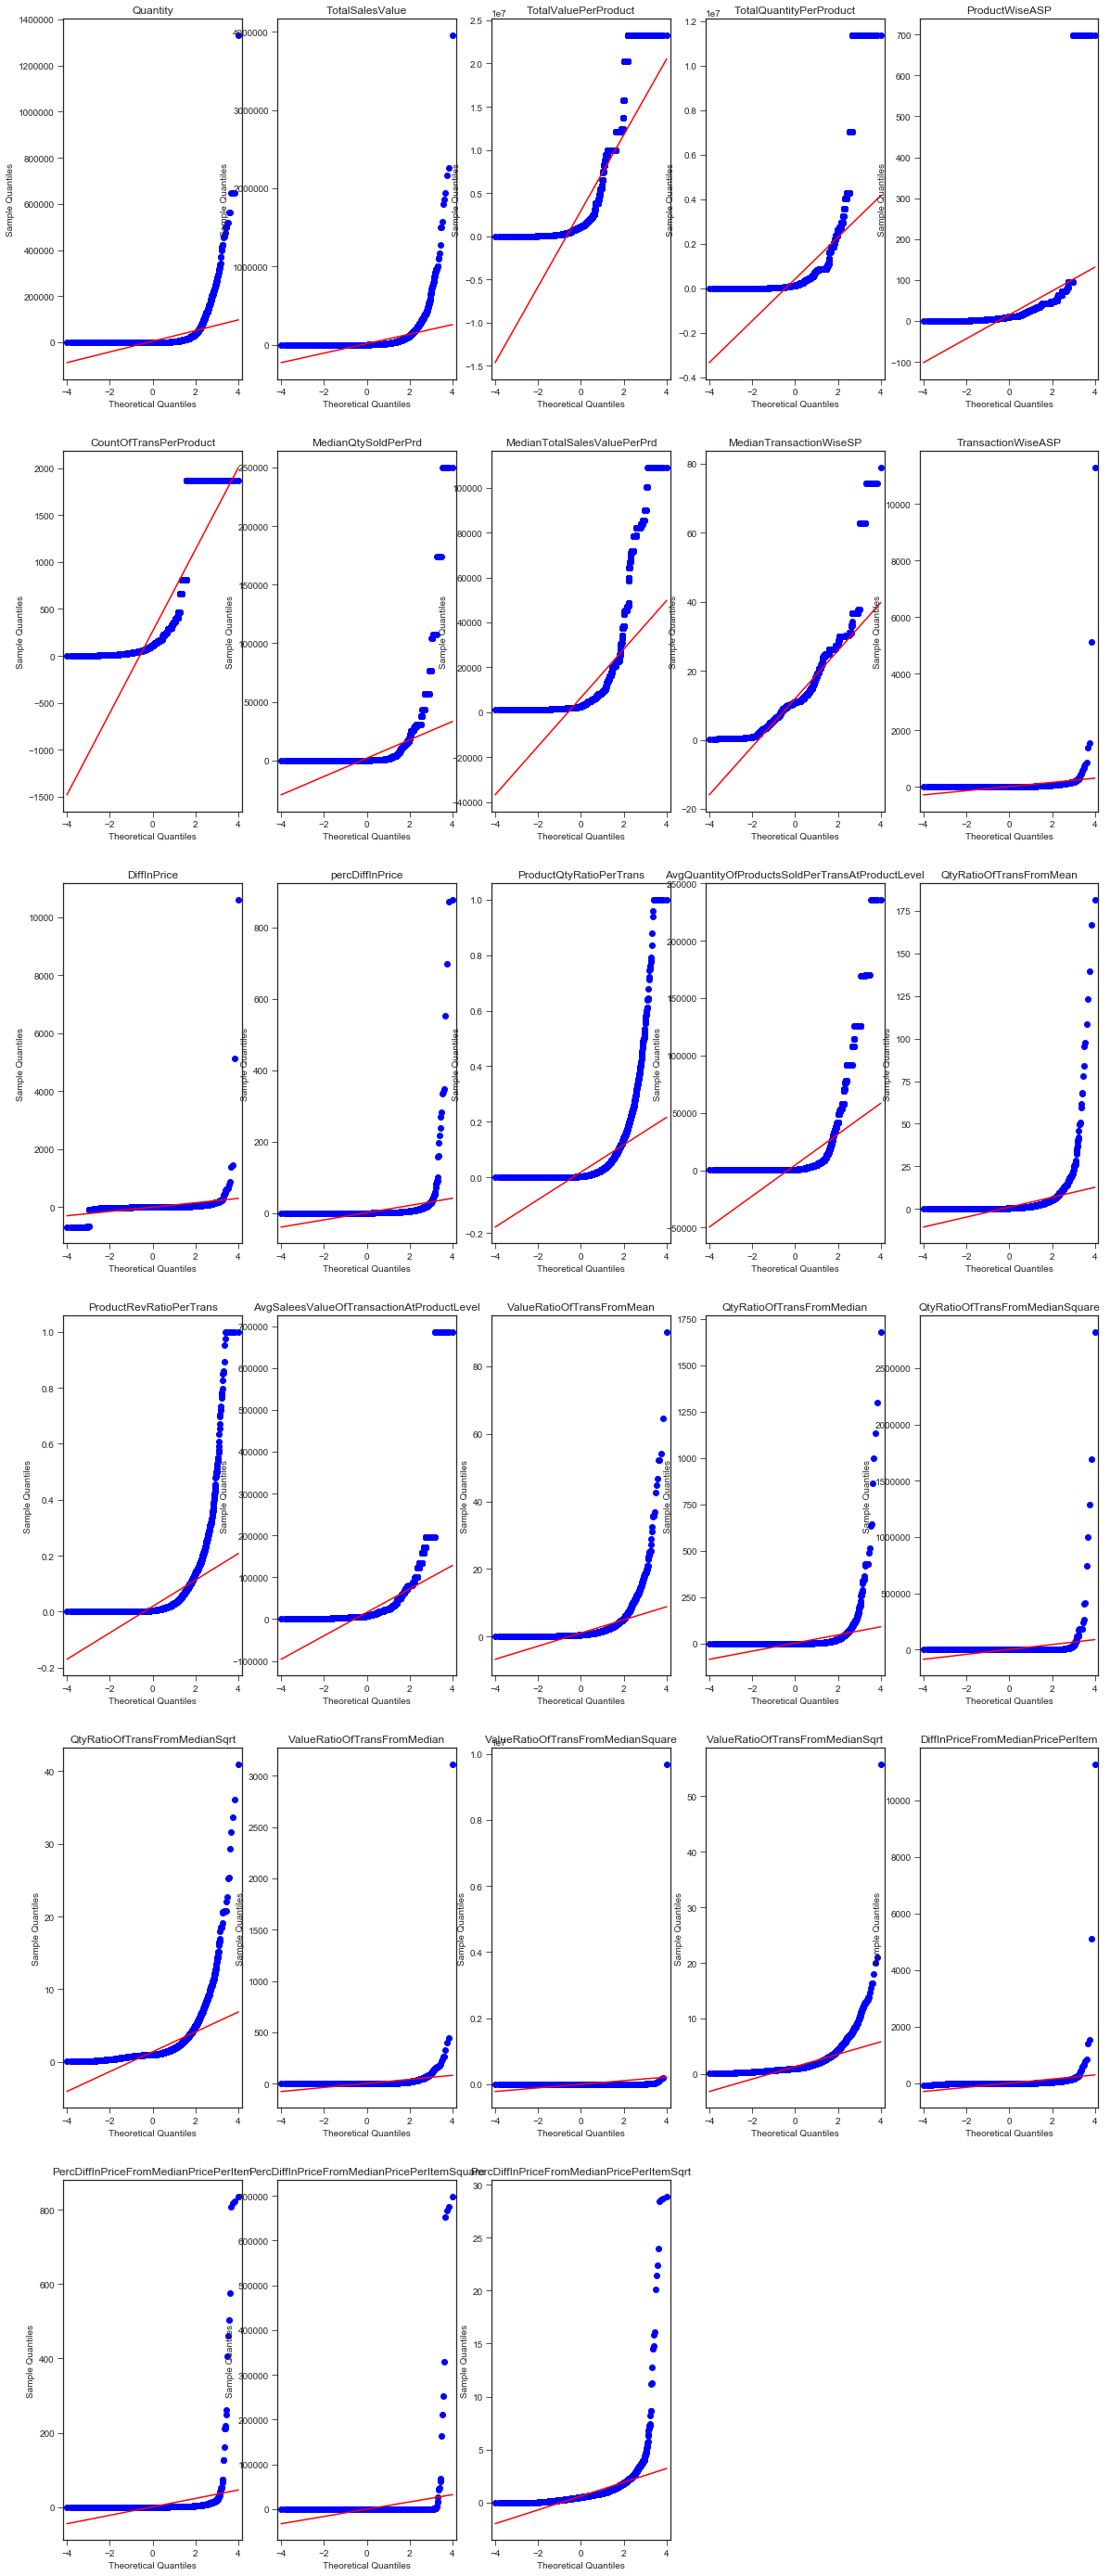

In [65]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 50

data = salesReportDataTrain_col_fillter.drop('Suspicious', axis=1)

fig = plt.figure()
left = -1.8   #x coordinate for text insert

for col_index in range(len(data.columns.tolist())):
    ax = fig.add_subplot(6, 5, col_index+1)
    plot_ret = sm.graphics.qqplot(data[data.columns.tolist()[col_index]], line='s', ax=ax)
    ax.title.set_text(data.columns.tolist()[col_index])

__Observation__
1. Normality of features is one of the main assumptions in many ML algo implementation.
2. None of the features are normally distributed, so in case we want to use such algo's we need to convert these features to normal distribution

#### Are the columns correlated?

In [66]:
corr = salesReportDataTrain_col_fillter.drop('Suspicious', axis=1).corr()
#trace = go.Heatmap(corr)
#data=[trace]


data = [go.Heatmap( z=corr.values.tolist(), 
                   x=salesReportDataTrain_col_fillter.drop('Suspicious', axis=1).columns,
                   y=salesReportDataTrain_col_fillter.drop('Suspicious', axis=1).columns,
                   colorscale='Viridis')]

layout = go.Layout(autosize=True,margin=go.Margin(l=170,r=300),
                   title = 'Correlation between derived columns',
                   xaxis = dict(tickangle = 23,tickfont=dict(size=7,color='black')),
                   yaxis = dict(tickangle = -45,tickfont=dict(size=8,color='black')))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Segment the data into IV & DV

In [67]:
X_train = salesReportDataTrain_col_fillter.drop('Suspicious', axis=1)
y_train = salesReportDataTrain_col_fillter['Suspicious']

In [68]:
num_col_split = list(X_train.select_dtypes(include='float').columns)
cat_col_split = list(X_train.select_dtypes(include='category').columns)

num_col_split
cat_col_split

['Quantity',
 'TotalSalesValue',
 'TotalValuePerProduct',
 'TotalQuantityPerProduct',
 'ProductWiseASP',
 'CountOfTransPerProduct',
 'MedianQtySoldPerPrd',
 'MedianTotalSalesValuePerPrd',
 'MedianTransactionWiseSP',
 'TransactionWiseASP',
 'DiffInPrice',
 'percDiffInPrice',
 'ProductQtyRatioPerTrans',
 'AvgQuantityOfProductsSoldPerTransAtProductLevel',
 'QtyRatioOfTransFromMean',
 'ProductRevRatioPerTrans',
 'AvgSaleesValueOfTransactionAtProductLevel',
 'ValueRatioOfTransFromMean',
 'QtyRatioOfTransFromMedian',
 'QtyRatioOfTransFromMedianSquare',
 'QtyRatioOfTransFromMedianSqrt',
 'ValueRatioOfTransFromMedian',
 'ValueRatioOfTransFromMedianSquare',
 'ValueRatioOfTransFromMedianSqrt',
 'DiffInPriceFromMedianPricePerItem',
 'PercDiffInPriceFromMedianPricePerItem',
 'PercDiffInPriceFromMedianPricePerItemSquare',
 'PercDiffInPriceFromMedianPricePerItemSqrt']

[]

### Build pipeline

In [69]:
num_transformer_step = {"scaler":"StandardScaler", "imputer":"mean"}
num_transformer = define_num_transformer(**num_transformer_step)

cat_transformer_step = {"dummyfication_onehot":"OneHotEncoder"}
cat_transformer = define_cat_transformer(**cat_transformer_step)

preprocessor = get_column_transformer(num_transformer, num_col_split, cat_transformer, cat_col_split)
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory='./',
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0))]), ['Quantity', 'TotalSalesValue', 'TotalValuePerProduct', 'Tota... dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True))]), [])])

In [70]:
#Pipeline steps to be added to imBalance pipeline
baseModel = LogisticRegression()
steps = {"preprocessor" : preprocessor, "baseModel": baseModel}
im_pipe_clf = add_to_pipeline(**steps)

### Build Grid

In [71]:
def simple_calssification_grid_space():
    return [{'classifier': [RandomForestClassifier(random_state=0, n_jobs=-1)],
             'classifier__n_estimators': [100],
             'classifier__criterion': ["gini"],
             'classifier__max_depth': [5],
             'classifier__bootstrap': [False],
             'classifier__warm_start': [True],
             'classifier__class_weight': ["balanced"],
            'classifier__max_features': ['auto'],
           'classifier__min_samples_leaf': [1]}]

In [72]:
#Search Space for base classifier
search_space = simple_calssification_grid_space()

#Define repeated KFold
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)


CV_grid_model = GridSearchCV(
    estimator=im_pipe_clf, param_grid=search_space, cv= rkf, scoring=cust_recall_score, n_jobs=-1, verbose=3, refit=True)
CV_grid_model.fit(X=X_train, y=y_train)

Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   52.5s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.3s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1c23d38da0>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory='./',
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('imputer', SimpleImputer(copy=True...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'classifier': [RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_sp...s_weight': ['balanced'], 'classifier__max_features': ['auto'], 'cl

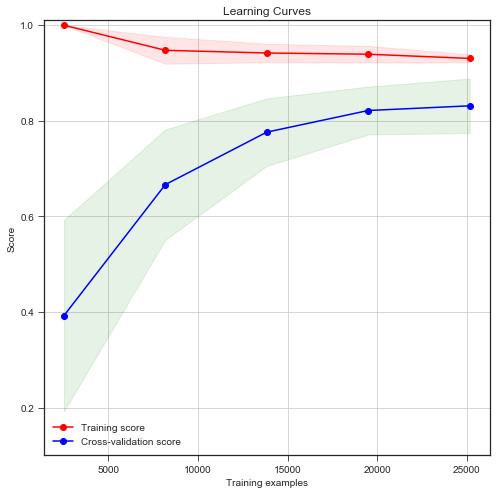

In [73]:
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)


steps = {"preprocessor" : preprocessor}
im_pipe_pre_process = add_to_pipeline(**steps)
estimator = CV_grid_model.best_estimator_.get_params()['classifier']
title = r"Learning Curves"
plot_learning_curve(estimator, title, im_pipe_pre_process.fit_transform(X_train), y_train, 
                       (0.1, 1.01), cv=cv, n_jobs=-1)

In [74]:
y_pred = evaluate_model(CV_grid_model, X_train, y_train)
y_pred

Accuracy score : 0.8130326930415978
classification_report :
                precision    recall  f1-score   support

           No     0.2131    0.7733    0.3341      1791
          Yes     0.2450    0.9313    0.3879       131
indeterminate     0.9841    0.8149    0.8916     29522

    micro avg     0.8130    0.8130    0.8130     31444
    macro avg     0.4807    0.8398    0.5379     31444
 weighted avg     0.9371    0.8130    0.8577     31444



array(['indeterminate', 'indeterminate', 'indeterminate', ...,
       'indeterminate', 'indeterminate', 'indeterminate'], dtype=object)

[[ 1385    23   383]
 [    4   122     5]
 [ 5111   353 24058]]


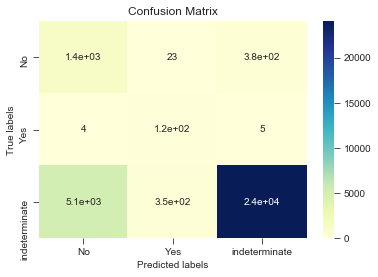

In [75]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
plot_confusion_matrix(y_train,y_pred)

### Feature importance

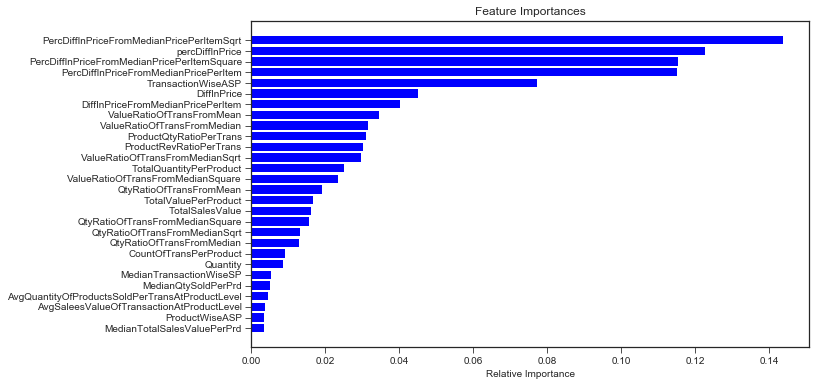

In [76]:
extm = CV_grid_model.best_estimator_.get_params()['classifier']
extm.fit(X_train, y_train)

features = X_train.columns
importances = extm.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

### Validate on test set

In [77]:
salesReportDataTest.head()
salesReportDataTest.shape

salesReportDataTestTrans = featureGenerator.transform(salesReportDataTest)
salesReportDataTestTrans.head()
salesReportDataTestTrans.shape

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
24344,Rep34445,C22046,PR6393,238,2415,indeterminate
33706,Rep43807,C21938,PR6381,120,6810,indeterminate
23342,Rep33443,C21980,PR6227,133,1835,indeterminate
10983,Rep21084,C22335,PR6278,112,1490,indeterminate
12505,Rep22606,C21178,PR6347,2140,8760,indeterminate


(10646, 6)

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
24344,Rep34445,C22046,PR6393,238,2415,indeterminate,231520.0,17446.0,13.270664,90.0,122.5,1705.0,12.462136,10.147059,-3.123605,-0.235377,0.013642,193.844444,1.227789,0.010431,2572.444444,0.938796,1.942857,3.774694,1.393864,1.416422,2.006252,1.190135,-2.315077,-0.185769,0.034510,0.431009
33706,Rep43807,C21938,PR6381,120,6810,indeterminate,855100.0,34347.0,24.895915,165.0,109.0,1765.0,14.779412,56.750000,31.854085,1.279490,0.003494,208.163636,0.576470,0.007964,5182.424242,1.314057,1.100917,1.212019,1.049246,3.858357,14.886918,1.964270,41.970588,2.839801,8.064470,1.685171
23342,Rep33443,C21980,PR6227,133,1835,indeterminate,1033308.0,117056.0,8.827467,350.0,154.0,1320.0,9.326087,13.796992,4.969525,0.562962,0.001136,334.445714,0.397673,0.001776,2952.308571,0.621547,0.863636,0.745868,0.929320,1.390152,1.932521,1.179047,4.470906,0.479398,0.229822,0.692386
10983,Rep21084,C22335,PR6278,112,1490,indeterminate,1264350.0,104988.0,12.042805,99.0,189.0,2470.0,10.720000,13.303571,1.260767,0.104690,0.001067,1060.484848,0.105612,0.001178,12771.212121,0.116669,0.592593,0.351166,0.769800,0.603239,0.363897,0.776685,2.583571,0.241005,0.058083,0.490922
12505,Rep22606,C21178,PR6347,2140,8760,indeterminate,1077990.0,215738.0,4.996755,29.0,2281.0,9305.0,5.112101,4.093458,-0.903297,-0.180777,0.009919,7439.241379,0.287664,0.008126,37172.068966,0.235661,0.938185,0.880191,0.968600,0.941429,0.886289,0.970273,-1.018643,-0.199261,0.039705,0.446387


(10646, 32)

In [78]:
col_to_drop = ['SalesPersonID', 'ProductID']
salesReportDataTest_col_fillter = salesReportDataTestTrans.drop(['ReportID'], axis=1).drop(
    col_to_drop, axis=1)
salesReportDataTest_col_fillter.head()
salesReportDataTest_col_fillter.shape
salesReportDataTest_col_fillter.dtypes

,Quantity,TotalSalesValue,Suspicious,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
24344,238,2415,indeterminate,231520.0,17446.0,13.270664,90.0,122.5,1705.0,12.462136,10.147059,-3.123605,-0.235377,0.013642,193.844444,1.227789,0.010431,2572.444444,0.938796,1.942857,3.774694,1.393864,1.416422,2.006252,1.190135,-2.315077,-0.185769,0.034510,0.431009
33706,120,6810,indeterminate,855100.0,34347.0,24.895915,165.0,109.0,1765.0,14.779412,56.750000,31.854085,1.279490,0.003494,208.163636,0.576470,0.007964,5182.424242,1.314057,1.100917,1.212019,1.049246,3.858357,14.886918,1.964270,41.970588,2.839801,8.064470,1.685171
23342,133,1835,indeterminate,1033308.0,117056.0,8.827467,350.0,154.0,1320.0,9.326087,13.796992,4.969525,0.562962,0.001136,334.445714,0.397673,0.001776,2952.308571,0.621547,0.863636,0.745868,0.929320,1.390152,1.932521,1.179047,4.470906,0.479398,0.229822,0.692386
10983,112,1490,indeterminate,1264350.0,104988.0,12.042805,99.0,189.0,2470.0,10.720000,13.303571,1.260767,0.104690,0.001067,1060.484848,0.105612,0.001178,12771.212121,0.116669,0.592593,0.351166,0.769800,0.603239,0.363897,0.776685,2.583571,0.241005,0.058083,0.490922
12505,2140,8760,indeterminate,1077990.0,215738.0,4.996755,29.0,2281.0,9305.0,5.112101,4.093458,-0.903297,-0.180777,0.009919,7439.241379,0.287664,0.008126,37172.068966,0.235661,0.938185,0.880191,0.968600,0.941429,0.886289,0.970273,-1.018643,-0.199261,0.039705,0.446387


(10646, 29)

Quantity                                             int64
TotalSalesValue                                      int64
Suspicious                                          object
TotalValuePerProduct                               float64
TotalQuantityPerProduct                            float64
ProductWiseASP                                     float64
CountOfTransPerProduct                             float64
MedianQtySoldPerPrd                                float64
MedianTotalSalesValuePerPrd                        float64
MedianTransactionWiseSP                            float64
TransactionWiseASP                                 float64
DiffInPrice                                        float64
percDiffInPrice                                    float64
ProductQtyRatioPerTrans                            float64
AvgQuantityOfProductsSoldPerTransAtProductLevel    float64
QtyRatioOfTransFromMean                            float64
ProductRevRatioPerTrans                            float

In [79]:
# Datatype conversions
salesReportDataTest_col_fillter[cat_col] = covert_var(salesReportDataTest_col_fillter[cat_col], "cat")
salesReportDataTest_col_fillter[num_col] = covert_var(salesReportDataTest_col_fillter[num_col], "num_float")    

X_test = salesReportDataTest_col_fillter.drop('Suspicious', axis=1)
y_test = salesReportDataTest_col_fillter['Suspicious']

y_test_pred = evaluate_model(CV_grid_model, X_test, y_test)
y_test_pred

Accuracy score : 0.8065940259252301
classification_report :
                precision    recall  f1-score   support

           No     0.2037    0.6980    0.3154       639
          Yes     0.2360    0.8444    0.3689        45
indeterminate     0.9767    0.8134    0.8876      9962

    micro avg     0.8066    0.8066    0.8066     10646
    macro avg     0.4722    0.7853    0.5240     10646
 weighted avg     0.9272    0.8066    0.8511     10646



array(['indeterminate', 'indeterminate', 'indeterminate', ...,
       'indeterminate', 'No', 'indeterminate'], dtype=object)

[[ 446    5  188]
 [   2   38    5]
 [1741  118 8103]]


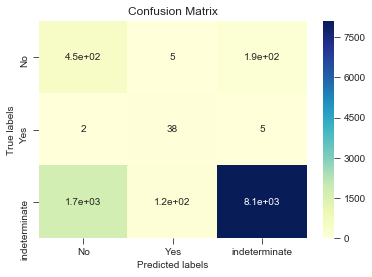

In [80]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
plot_confusion_matrix(y_test,y_test_pred)

### ROC/ AUC 
Evaluate selected model

In [81]:
multiclass_roc_auc_score(y_test,y_test_pred, average=None)

array([0.91642088])

__Observation__
1. Train dataset has "Yes's" recall of 93% & for test 85%, still signifies presence of variance. But significant improvement as compared to previous models.

### Validate on Actual test set

In [82]:
salesReportDataTestActual.head()
salesReportDataTestActual.shape
salesReportDataTestActualTrans = featureGenerator.transform(salesReportDataTestActual)
salesReportDataTestActualTrans.head()
salesReportDataTestActualTrans.shape

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue
0,Rep70101,C21844,PR6483,102,1115
1,Rep70102,C21844,PR6251,102,1050
2,Rep70103,C21844,PR6253,344,3490
3,Rep70104,C21844,PR6378,108,1095
4,Rep70105,C21844,PR6463,146,1055


(9135, 5)

,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
0,Rep70101,C21844,PR6483,102,1115,92140.0,8632.0,10.674235,50,138.5,1422.5,9.829235,10.931373,0.257137,0.024090,0.011816,172.64000,0.590825,0.012101,1842.800000,0.605058,0.736462,0.542376,0.858174,0.783831,0.614391,0.885342,1.102138,0.112129,0.012573,0.334856
1,Rep70102,C21844,PR6251,102,1050,315045.0,33816.0,9.316448,80,157.0,1985.0,10.861266,10.294118,0.977670,0.104940,0.003016,422.70000,0.241306,0.003333,3938.062500,0.266629,0.649682,0.422086,0.806028,0.528967,0.279806,0.727301,-0.567148,-0.052217,0.002727,0.228511
2,Rep70103,C21844,PR6253,344,3490,9932447.0,861222.0,11.532969,1864,158.0,2017.5,11.191206,10.145349,-1.387621,-0.120318,0.000399,462.02897,0.744542,0.000351,5328.565987,0.654960,2.177215,4.740266,1.475539,1.729864,2.992428,1.315243,-1.045857,-0.093453,0.008734,0.305702
3,Rep70104,C21844,PR6378,108,1095,1405065.0,22143.0,63.454139,125,114.0,3185.0,27.342342,10.138889,-53.315250,-0.840217,0.004877,177.14400,0.609673,0.000779,11240.520000,0.097415,0.947368,0.897507,0.973329,0.343799,0.118198,0.586344,-17.203453,-0.629187,0.395877,0.793213
4,Rep70105,C21844,PR6463,146,1055,35520.0,3753.0,9.464428,32,103.5,1080.0,10.025233,7.226027,-2.238401,-0.236507,0.038902,117.28125,1.244871,0.029702,1110.000000,0.950450,1.410628,1.989871,1.187699,0.976852,0.954240,0.988358,-2.799206,-0.279216,0.077962,0.528409


(9135, 31)

#### Do required Preprocessing

In [83]:
col_to_drop = ['SalesPersonID', 'ProductID']
salesReportDataTestActual_col_fillter = salesReportDataTestActualTrans.drop(['ReportID'], axis=1).drop(
    col_to_drop, axis=1)
salesReportDataTestActual_col_fillter.head()
salesReportDataTestActual_col_fillter.shape
salesReportDataTestActual_col_fillter.dtypes

,Quantity,TotalSalesValue,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
0,102,1115,92140.0,8632.0,10.674235,50,138.5,1422.5,9.829235,10.931373,0.257137,0.024090,0.011816,172.64000,0.590825,0.012101,1842.800000,0.605058,0.736462,0.542376,0.858174,0.783831,0.614391,0.885342,1.102138,0.112129,0.012573,0.334856
1,102,1050,315045.0,33816.0,9.316448,80,157.0,1985.0,10.861266,10.294118,0.977670,0.104940,0.003016,422.70000,0.241306,0.003333,3938.062500,0.266629,0.649682,0.422086,0.806028,0.528967,0.279806,0.727301,-0.567148,-0.052217,0.002727,0.228511
2,344,3490,9932447.0,861222.0,11.532969,1864,158.0,2017.5,11.191206,10.145349,-1.387621,-0.120318,0.000399,462.02897,0.744542,0.000351,5328.565987,0.654960,2.177215,4.740266,1.475539,1.729864,2.992428,1.315243,-1.045857,-0.093453,0.008734,0.305702
3,108,1095,1405065.0,22143.0,63.454139,125,114.0,3185.0,27.342342,10.138889,-53.315250,-0.840217,0.004877,177.14400,0.609673,0.000779,11240.520000,0.097415,0.947368,0.897507,0.973329,0.343799,0.118198,0.586344,-17.203453,-0.629187,0.395877,0.793213
4,146,1055,35520.0,3753.0,9.464428,32,103.5,1080.0,10.025233,7.226027,-2.238401,-0.236507,0.038902,117.28125,1.244871,0.029702,1110.000000,0.950450,1.410628,1.989871,1.187699,0.976852,0.954240,0.988358,-2.799206,-0.279216,0.077962,0.528409


(9135, 28)

Quantity                                             int64
TotalSalesValue                                      int64
TotalValuePerProduct                               float64
TotalQuantityPerProduct                            float64
ProductWiseASP                                     float64
CountOfTransPerProduct                               int64
MedianQtySoldPerPrd                                float64
MedianTotalSalesValuePerPrd                        float64
MedianTransactionWiseSP                            float64
TransactionWiseASP                                 float64
DiffInPrice                                        float64
percDiffInPrice                                    float64
ProductQtyRatioPerTrans                            float64
AvgQuantityOfProductsSoldPerTransAtProductLevel    float64
QtyRatioOfTransFromMean                            float64
ProductRevRatioPerTrans                            float64
AvgSaleesValueOfTransactionAtProductLevel          float

In [84]:
cat_col = []
num_col = np.setdiff1d(salesReportDataTestActual_col_fillter.columns, cat_col).tolist()

cat_col
num_col

salesReportDataTestActual_col_fillter[num_col] = covert_var(salesReportDataTestActual_col_fillter[num_col], "num_float")    

# Datatype conversions
salesReportDataTestActual_col_fillter.head()
salesReportDataTestActual_col_fillter.dtypes

[]

['AvgQuantityOfProductsSoldPerTransAtProductLevel',
 'AvgSaleesValueOfTransactionAtProductLevel',
 'CountOfTransPerProduct',
 'DiffInPrice',
 'DiffInPriceFromMedianPricePerItem',
 'MedianQtySoldPerPrd',
 'MedianTotalSalesValuePerPrd',
 'MedianTransactionWiseSP',
 'PercDiffInPriceFromMedianPricePerItem',
 'PercDiffInPriceFromMedianPricePerItemSqrt',
 'PercDiffInPriceFromMedianPricePerItemSquare',
 'ProductQtyRatioPerTrans',
 'ProductRevRatioPerTrans',
 'ProductWiseASP',
 'QtyRatioOfTransFromMean',
 'QtyRatioOfTransFromMedian',
 'QtyRatioOfTransFromMedianSqrt',
 'QtyRatioOfTransFromMedianSquare',
 'Quantity',
 'TotalQuantityPerProduct',
 'TotalSalesValue',
 'TotalValuePerProduct',
 'TransactionWiseASP',
 'ValueRatioOfTransFromMean',
 'ValueRatioOfTransFromMedian',
 'ValueRatioOfTransFromMedianSqrt',
 'ValueRatioOfTransFromMedianSquare',
 'percDiffInPrice']

,Quantity,TotalSalesValue,TotalValuePerProduct,TotalQuantityPerProduct,ProductWiseASP,CountOfTransPerProduct,MedianQtySoldPerPrd,MedianTotalSalesValuePerPrd,MedianTransactionWiseSP,TransactionWiseASP,DiffInPrice,percDiffInPrice,ProductQtyRatioPerTrans,AvgQuantityOfProductsSoldPerTransAtProductLevel,QtyRatioOfTransFromMean,ProductRevRatioPerTrans,AvgSaleesValueOfTransactionAtProductLevel,ValueRatioOfTransFromMean,QtyRatioOfTransFromMedian,QtyRatioOfTransFromMedianSquare,QtyRatioOfTransFromMedianSqrt,ValueRatioOfTransFromMedian,ValueRatioOfTransFromMedianSquare,ValueRatioOfTransFromMedianSqrt,DiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItem,PercDiffInPriceFromMedianPricePerItemSquare,PercDiffInPriceFromMedianPricePerItemSqrt
0,102.0,1115.0,92140.0,8632.0,10.674235,50.0,138.5,1422.5,9.829235,10.931373,0.257137,0.024090,0.011816,172.64000,0.590825,0.012101,1842.800000,0.605058,0.736462,0.542376,0.858174,0.783831,0.614391,0.885342,1.102138,0.112129,0.012573,0.334856
1,102.0,1050.0,315045.0,33816.0,9.316448,80.0,157.0,1985.0,10.861266,10.294118,0.977670,0.104940,0.003016,422.70000,0.241306,0.003333,3938.062500,0.266629,0.649682,0.422086,0.806028,0.528967,0.279806,0.727301,-0.567148,-0.052217,0.002727,0.228511
2,344.0,3490.0,9932447.0,861222.0,11.532969,1864.0,158.0,2017.5,11.191206,10.145349,-1.387621,-0.120318,0.000399,462.02897,0.744542,0.000351,5328.565987,0.654960,2.177215,4.740266,1.475539,1.729864,2.992428,1.315243,-1.045857,-0.093453,0.008734,0.305702
3,108.0,1095.0,1405065.0,22143.0,63.454139,125.0,114.0,3185.0,27.342342,10.138889,-53.315250,-0.840217,0.004877,177.14400,0.609673,0.000779,11240.520000,0.097415,0.947368,0.897507,0.973329,0.343799,0.118198,0.586344,-17.203453,-0.629187,0.395877,0.793213
4,146.0,1055.0,35520.0,3753.0,9.464428,32.0,103.5,1080.0,10.025233,7.226027,-2.238401,-0.236507,0.038902,117.28125,1.244871,0.029702,1110.000000,0.950450,1.410628,1.989871,1.187699,0.976852,0.954240,0.988358,-2.799206,-0.279216,0.077962,0.528409


Quantity                                           float64
TotalSalesValue                                    float64
TotalValuePerProduct                               float64
TotalQuantityPerProduct                            float64
ProductWiseASP                                     float64
CountOfTransPerProduct                             float64
MedianQtySoldPerPrd                                float64
MedianTotalSalesValuePerPrd                        float64
MedianTransactionWiseSP                            float64
TransactionWiseASP                                 float64
DiffInPrice                                        float64
percDiffInPrice                                    float64
ProductQtyRatioPerTrans                            float64
AvgQuantityOfProductsSoldPerTransAtProductLevel    float64
QtyRatioOfTransFromMean                            float64
ProductRevRatioPerTrans                            float64
AvgSaleesValueOfTransactionAtProductLevel          float

#### Predict Suspiciousness

In [85]:
X_test = salesReportDataTestActual_col_fillter.copy()
y_test_pred = CV_grid_model.predict_proba(X_test)
y_test_pred

array([[0.20587983, 0.07089001, 0.72323016],
       [0.23477186, 0.05730386, 0.70792428],
       [0.46252206, 0.05732792, 0.48015002],
       ...,
       [0.65328616, 0.08081794, 0.26589591],
       [0.25455779, 0.05167973, 0.69376248],
       [0.2007286 , 0.04583305, 0.75343835]])

In [86]:
y_test_actual_pred = CV_grid_model.predict(X_test)
y_test_op = pd.DataFrame(y_test_actual_pred).rename({0:'Suspicious'}, axis=1)
y_test_op.head()

,Suspicious
0,indeterminate
1,indeterminate
2,indeterminate
3,indeterminate
4,indeterminate


#### Analyze distribution of prediction

In [87]:
y_test_op['Suspicious'].value_counts()
(y_test_op["Suspicious"].value_counts()/y_test_op.shape[0])*100

indeterminate    7099
No               1874
Yes               162
Name: Suspicious, dtype: int64

indeterminate    77.712096
No               20.514505
Yes               1.773399
Name: Suspicious, dtype: float64

#### Prepare data for writing to o/p file

In [88]:
y_test_op_conct = pd.concat([salesReportDataTestActual[['ReportID']], y_test_op], axis=1)
y_test_op_conct.head()

,ReportID,Suspicious
0,Rep70101,indeterminate
1,Rep70102,indeterminate
2,Rep70103,indeterminate
3,Rep70104,indeterminate
4,Rep70105,indeterminate


In [89]:
y_test_pred_ref = y_test_op_conct.replace({'Yes': 1, 'No': 2, 'indeterminate':3})
y_test_pred_ref.head()

,ReportID,Suspicious
0,Rep70101,3
1,Rep70102,3
2,Rep70103,3
3,Rep70104,3
4,Rep70105,3


In [90]:
y_test_pred_ref[['ReportID', 'Suspicious']].to_csv(
    path_or_buf="/Users/samyam/Documents/Samya/GIT/insofe/Final_PHD/PartB/finalSubmission/submission.csv", 
    index=False)


## Report Summary

### One-point-view

1. This is a High Variance dataset.
2. Features are generated to the best of understanding of domain.
3. Main motive of the activity was to generalize the model.
4. As we are interested in only Recall of Yes, so a scenario can be predict all test data as 'Yes', that would give a perfect recall of 1. But that unlikely & realistically (in business terms) stating all transactions as Suspicious is highly uncalled for. So my motive was to strike a balance between uplifting the Recall for Yes without exploding the number of total Predicted (TP+FP) 'Yes'. 


### Business aspect
1. We are able to capture 76% of the total Suspicious transactions.
2. Though the aim is to get high Recall (capture as many Suspicious transactions as possible), but we need to keep Precision also in mind, else very poor Precision may need lead to incursion of add-on cost for business if they take actions on Suspicious transactions.


### Technical aspect
1. Some other activities that were performed as part of the task but not covered in the notebook:-
    
    a. As a best practice, I also retrained the final model on entire dataset, but no improvements were observed.
    
    b. Also tried oversampling with specific sampling_strategy (2:1:1), this increased the Recall on Test but at the cost of huge increase in count f predicted Yes.
    
    c. As described earlier, there are many records with different ReportID, but same other data points (including target label), So I considered dropping those duplicates as that may lead to over-fitting, but performed in similar lines.
    
    d. We also reduced the number of features generated based on feature importance, But no significant improvement observed in recall
    
    e. Another assumption that i tried out was, the deviation in average selling price per transaction in dependent on product, so kept ProductID as one of the IV columns, but the results showed no significant improvements.


2. Mentioned above that the features are not from normal distribution, but as our algo performs significantly well on Random Forest, we don't need to convert them into normal distribution. __Note__ : Distance based algo like RF is not affected by Normality of data.


### Scope for Improvements and next steps
1. More in-depth business knowledge required to generate relevant features.
2. Sophisticated(preferably variance reduction) algo(s) needed to be tried so as to reduce variance.
3. Better understanding of internals of different algorithms required for tuning. Faced challenges in this area during the task.

### Request for acceptance of submission
As part of multiple submissions of prediction file, I request to accept the one with Recall of 76%. As part of this prediction the model predicted total of 162 data points as 'Yes'.